# Huber loss  

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Not really needed, but nicer plots
import seaborn as sns; sns.set(); sns.set_context("talk")

import emcee
import corner

In [5]:
# note that x and y will be used as global arrays
x = np.array([ 0,  3,  9, 14, 15, 19, 20, 21, 30, 35,
              40, 41, 42, 43, 54, 56, 67, 69, 72, 88])
y = np.array([33, 68, 34, 34, 37, 71, 37, 44, 48, 49,
              53, 49, 50, 48, 56, 60, 61, 63, 44, 71])
sig0 = 3.
e = sig0*np.ones_like(y)

In [7]:
def residuals(theta, x=x, y=y, sigma0=sig0):
    """
    Residuals between data y (a vector at points x) and the theoretical model,
    which here is a straight line with theta[0] = b and theta[1] = m.
    """
    delta_y = y - theta[0] - theta[1] * x
    return delta_y / sigma0

 
def log_posterior_gaussian(theta):
    """
    Returns the logarithm of the posterior, with a standard chi^2 likelihood 
    in terms of the residuals, with Gaussian errors as specified and a
    uniform prior assumed for theta between 0 and 100.
    """
    if (all(theta > 0) and all(theta < 100)):
        return -0.5 * np.sum(residuals(theta)**2)
    else:
        return -np.inf  # recall log(0) = -inf    

MLE: theta0 = 41.2, theta1 = 0.25


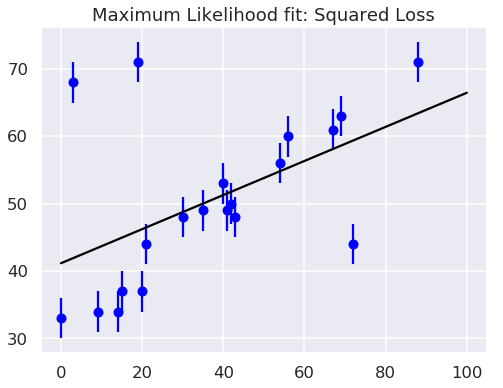

In [8]:
from scipy import optimize

def squared_loss(theta, x=x, y=y, sigma0=sig0):
    """Loss function is sum of squared residuals divided by 2, which
        is what we usually call chi^2 / 2. 
    """
    delta_y = y - theta[0] - theta[1] * x
    return np.sum(0.5 * (delta_y / sigma0) ** 2)

# Find the maximum likelihood estimate (MLE) for theta by minimizing the
#  square_loss function using scipy.optimize.fmin. (Minimizing chi^2 gives
#  the same result as maximizing e^{chi^2/2}.)
theta_MLE = optimize.fmin(squared_loss, [0, 0], disp=False)
print(f"MLE: theta0 = {theta_MLE[0]:.1f}, theta1 = {theta_MLE[1]:.2f}")

# Plot the MLE fit versus the data
xfit = np.linspace(0, 100)
yfit = theta_MLE[0] + theta_MLE[1] * xfit

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.errorbar(x, y, sig0, fmt='o', color='blue')
ax.plot(xfit, yfit, color='black')
ax.set_title('Maximum Likelihood fit: Squared Loss');

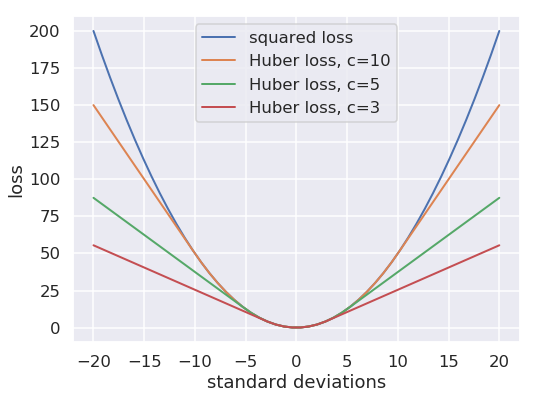

In [9]:
t = np.linspace(-20, 20)

def huber_loss(t, c=3):
    """
    Returns either a squared lost function or a linear (abolute value) loss
     function, depending on whether the |argument| is < c or >= c.
    """
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(t, 0.5 * t ** 2, label="squared loss", lw=2)
for c in (10, 5, 3):
    ax.plot(t, huber_loss(t, c), label=f"Huber loss, c={c}", lw=2)
ax.set(ylabel='loss', xlabel='standard deviations')
ax.legend(loc='best');

Huber: theta0 = 32.8, theta1 = 0.43


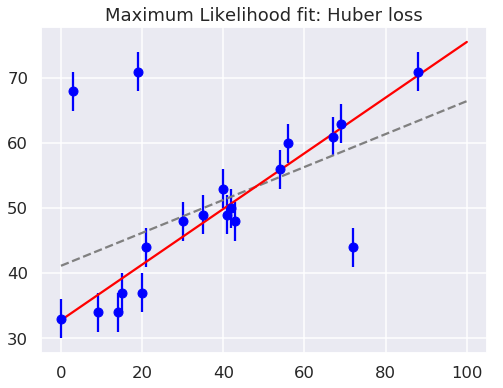

In [28]:
def total_huber_loss(theta, x=x, y=y, sigma0=sig0, c=1):
    return huber_loss((y - theta[0] - theta[1] * x) / sigma0, c).sum()

# minimize the total Huber loss for c=3
theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)
print(f"Huber: theta0 = {theta2[0]:.1f}, theta1 = {theta2[1]:.2f}")

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, sig0, fmt='o', color='blue')
ax.plot(xfit, theta_MLE[0] + theta_MLE[1] * xfit, color='gray',ls='--')
ax.plot(xfit, theta2[0] + theta2[1] * xfit, color='red')
ax.set_title('Maximum Likelihood fit: Huber loss');

## A brief explaination how each of the method work:

Huber loss is a loss function used in regressions that less sensitive to outliers than square error loss
function. The Huber loss function is strongly convex, and is able to combine the best properties of the squared loss and absolute loss using delta functions. Note, the use of c is just a by product of integration. Its value can be determined by setting the function of integration to zero and solving for such depending on the value of the delta. 

## Questions: 

I do not quite understand what purpose this function serves. When it seems as though the conservative and Cauchy does just as good of a job. 

I am still struggling to understand how does placing lower values of c get us better fits when c is just some integral constant variable. C = 1 does a better job than three. Is this always the case for all data? 

# A conservative formulation

In [14]:
def single_gaussian_likelihood(R_i, sigma_0):
    """
    This likelihood is a zero-mean gaussian with standard deviation sigma_0.
    """
    rsq = R_i**2
    return np.exp(-rsq / 2.) / (sigma_0 * np.sqrt(2 * np.pi ))

def single_conservative_likelihood(R_i, sigma_0):
    """
    This likelihood is the result of marginalizing over the standard 
    deviation sigma from sigma0 to infinity with a prior sigma0 / sigma^2.
    """
    rsq = R_i**2
    return (1-np.exp(-rsq / 2.)) / (sigma_0 * np.sqrt(2. * np.pi) * rsq)

def single_cauchy_likelihood(R_i, sigma_0):
    """
    This likelihood is a Cauchy distribution.
    """
    rsq = R_i**2
    return 1 / (sigma_0 * np.pi * np.sqrt(2) * (1. + rsq / 2.))

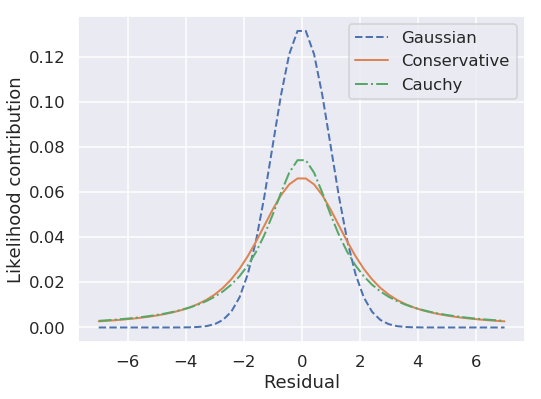

In [15]:
r = np.linspace(-7, 7)

fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(r, single_gaussian_likelihood(r,sig0), label="Gaussian", 
        lw=2, ls='--')
ax.plot(r, single_conservative_likelihood(r,sig0), label="Conservative", 
        lw=2, ls='-')
ax.plot(r, single_cauchy_likelihood(r,sig0), label="Cauchy", 
        lw=2, ls='-.')
ax.set(ylabel='Likelihood contribution',xlabel='Residual')
ax.legend(loc='best');

In [16]:
# Conservative error likelihood
def log_posterior_conservative(theta):
    """
    Log posterior with uniform prior for theta and a Gaussian likelihood
    """
    if (all(theta > 0) and all(theta < 100)):
        r2 = residuals(theta)**2
        return np.sum( np.log((1-np.exp(-r2/2))/r2) )
    else:
        return -np.inf  # recall log(0) = -inf    

## A brief explaination how each of the method work:

All of the points are treated with the same suspicion, therefore no one point is singled out. By doing so, each point holds the same weight. The distribution is more wide spread(increase in the width of the base and longer tails). Sigma is the only parameter, but it has to be greater than sigma_non, Sigma_non being the error bar values. 

## Questions:

What about this method is conservative? Usually conservative means "tending to oppose change." But the fact this equation accounts for outliers and does so by going as far to have larger tails, does not seem "conservative" 

# The Cauchy formulation

In [24]:
# Cauchy likelihood
def log_posterior_cauchy(theta):
    """
    Log posterior with Cauchy likelihood and uniform prior for theta
    """
    if (all(theta > 0) and all(theta < 100)):
        R_sq = residuals(theta)**2
        return - np.sum( np.log(1 + R_sq/2) )
    else:
        return -np.inf  # recall log(0) = -inf    

emcee sampling (version: ) 2.2.1
10 walkers:
Log posterior: Std Gaussian
... EMCEE sampler performing 1000 warnup iterations.
... EMCEE sampler performing 10000 samples.
CPU times: user 8.04 s, sys: 0 ns, total: 8.04 s
Wall time: 8.1 s
done


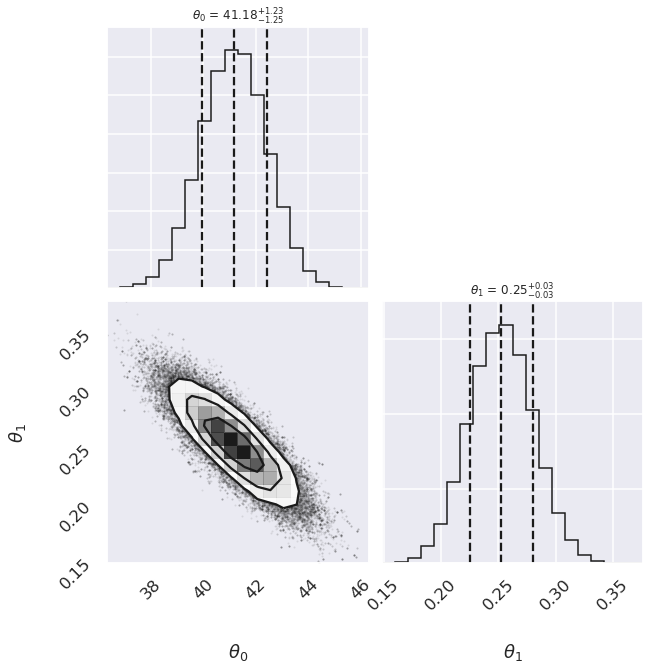

Log posterior: Conservative
... EMCEE sampler performing 1000 warnup iterations.
... EMCEE sampler performing 10000 samples.
CPU times: user 8.77 s, sys: 11.9 ms, total: 8.78 s
Wall time: 8.84 s
done


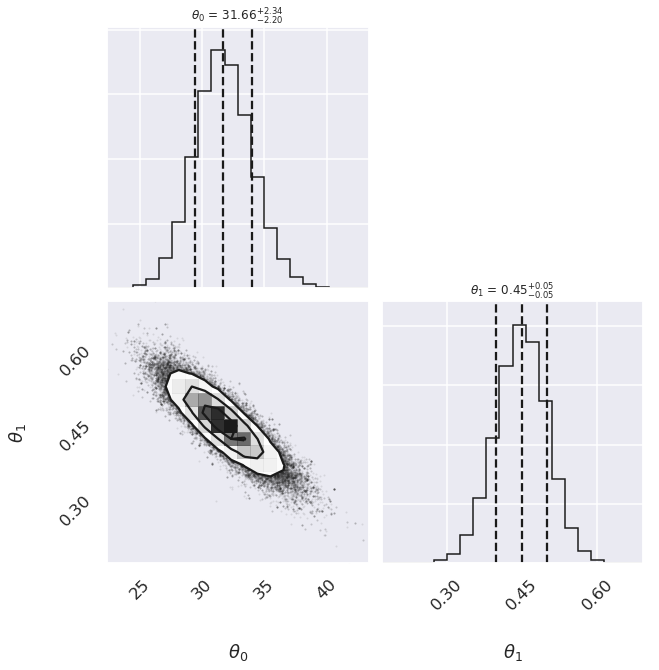

Log posterior: Cauchy
... EMCEE sampler performing 1000 warnup iterations.
... EMCEE sampler performing 10000 samples.
CPU times: user 8.16 s, sys: 23.9 ms, total: 8.19 s
Wall time: 8.21 s
done


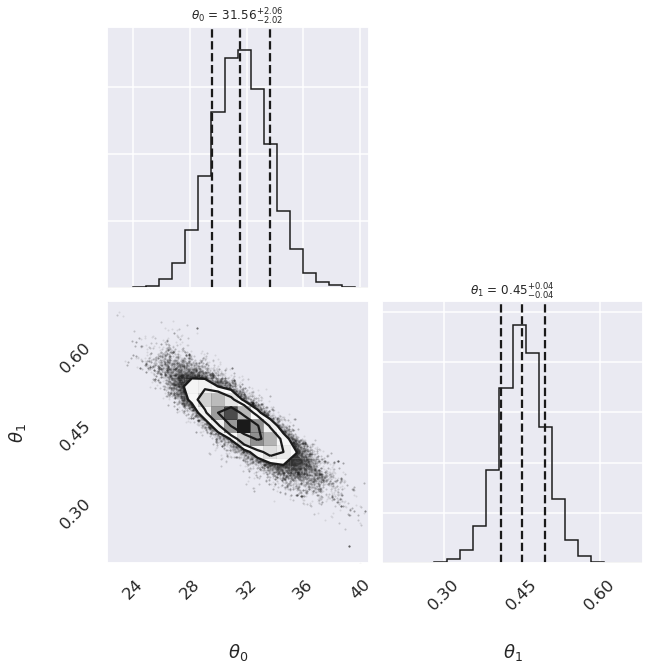

In [25]:
print('emcee sampling (version: )', emcee.__version__)

ndim = 2 # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nwarmup = 1000  # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take

print(f'{nwalkers} walkers:')

# Starting guesses close to the MLE
starting_guesses = np.abs(np.random.normal(1, 1, (nwalkers, 2)))
starting_guesses[:,0] += theta_MLE[0]
starting_guesses[:,1] /= 10
starting_guesses[:,1] += theta_MLE[1]

logps = [log_posterior_gaussian, log_posterior_conservative,
         log_posterior_cauchy]
approaches = ['Std Gaussian', 'Conservative','Cauchy']
mean_68CR = []

for ilogp,logp in enumerate(logps):
    print(f"Log posterior: {approaches[ilogp]}")
    # Sample the posterior distribution
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logp)

    # Warm-up
    if nwarmup > 0:
        print(f'... EMCEE sampler performing {nwarmup} warnup iterations.')
        pos, prob, state = sampler.run_mcmc(starting_guesses, nwarmup)
        sampler.reset()
    else:
        pos = starting_guesses
    
    # Perform iterations, starting at the final position from the warmup.
    print(f'... EMCEE sampler performing {nsteps} samples.')
    %time sampler.run_mcmc(pos, nsteps)
    print("done")

    samples = sampler.flatchain
    lnposts = sampler.lnprobability
    
    # Extract mean and 68% CR
    th0_mcmc, th1_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
    mean_68CR.append((th0_mcmc,th1_mcmc))
    
    # make a corner plot with the posterior distribution
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    corner.corner(samples,labels=[r"$\theta_0$", r"$\theta_1$"],
                       quantiles=[0.16, 0.5, 0.84],fig=fig,
                       show_titles=True, title_kwargs={"fontsize": 12});
    plt.show()

Summary:             Mean offset  68% CR     Mean slope     68% CR
        Std Gaussian    41.18   -1.25,+1.23     0.252    -0.028,+0.027
        Conservative    31.66   -2.20,+2.34     0.449    -0.050,+0.052
              Cauchy    31.56   -2.02,+2.06     0.451    -0.043,+0.042


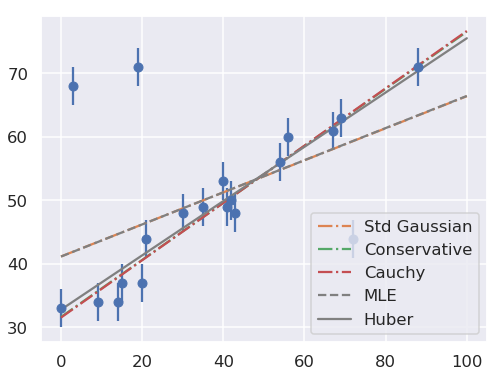

In [26]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, sig0, fmt='o')

print("Summary:             Mean offset  68% CR     Mean slope     68% CR")
for i,approach in enumerate(approaches):
    ((th0,th0pos,th0neg),(th1,th1neg,th1pos)) = mean_68CR[i]
    print(f"{approach:>20s}    {th0:5.2f}   -{th0neg:4.2f},+{th0pos:4.2f}",\
         f"    {th1:5.3f}    -{th1neg:5.3f},+{th1pos:5.3f}")
    ax.plot(xfit, th0 + th1 * xfit, label=approach,  ls='-.')
    
ax.plot(xfit, theta_MLE[0] + theta_MLE[1] * xfit, 
        color='gray',ls='--',label='MLE')
ax.plot(xfit, theta2[0] + theta2[1] * xfit, 
        color='gray',ls='-',label='Huber')
ax.legend(loc='best');

## A brief explaination how each of the method work

The Cauchy method work simliar to conservative method. The same sigma parameter is introduced, but instead of sigma being greater than sigma_non, there are about equal. This permits a more equal distribution where the tail will have more weight since the outliers, of course, are on the outside of the distribution. Futhermore, it tries to account for these outliers by marginalizing the a parameter using a t-distribution.  

## Questions

I still do not understand how these methods, Cauchy and conservative, are able to account for both points that are not outliers and outliers.

## Many nuisance parameters

In [17]:
# theta will be an array of length 2 + N, where N is the number of points
# theta[0] is the intercept, theta[1] is the slope,
# and theta[2 + i] is the weight g_i

def log_prior(theta):
    #g_i needs to be between 0 and 1
    if (all(theta[2:] > 0) and all(theta[2:] < 1)):
        return 0
    else:
        return -np.inf  # recall log(0) = -inf

def log_likelihood(theta, x, y, e, sigma_B):
    dy = y - theta[0] - theta[1] * x
    g = np.clip(theta[2:], 0, 1)  # g<0 or g>1 leads to NaNs in logarithm
    logL1 = np.log(g) - 0.5 * np.log(2 * np.pi * e**2) - 0.5 * (dy / e)**2
    logL2 = np.log(1 - g) - 0.5 * np.log(2 * np.pi * sigma_B**2) \
            - 0.5 * (dy / sigma_B)**2
    return np.sum(np.logaddexp(logL1, logL2))

def log_posterior(theta, x, y, e, sigma_B):
    return log_prior(theta) + log_likelihood(theta, x, y, e, sigma_B)

In [18]:
# Note that this step will take a few minutes to run!

ndim = 2 + len(x)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 15000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = np.random.normal(theta_MLE, 1, (nwalkers, 2))
starting_guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim - 2))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=[x, y, sig0, 50])
sampler.run_mcmc(starting_guesses, nsteps)

samples = sampler.chain[:, nburn:, :].reshape(-1, ndim)

/home/cristopher6/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/home/cristopher6/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


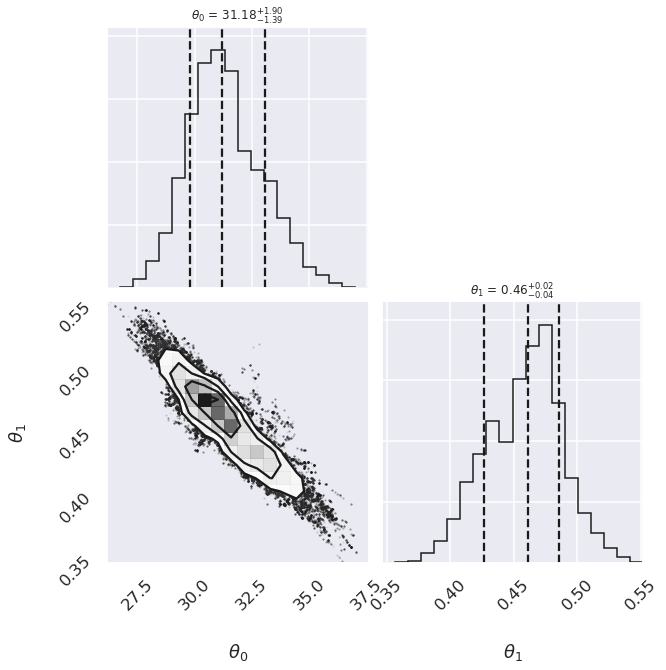

In [19]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
# plot a corner plot with the posterior distribution
# Note that the intercept and the slope correspond to 
#  the first two entries in the parameter array.
fig = corner.corner(samples[:,:2], labels=[r"$\theta_0$", r"$\theta_1$"],
                    quantiles=[0.16, 0.5, 0.84],fig=fig,
                    show_titles=True, title_kwargs={"fontsize": 12})

g1 mean: 0.65
g2 mean: 0.34


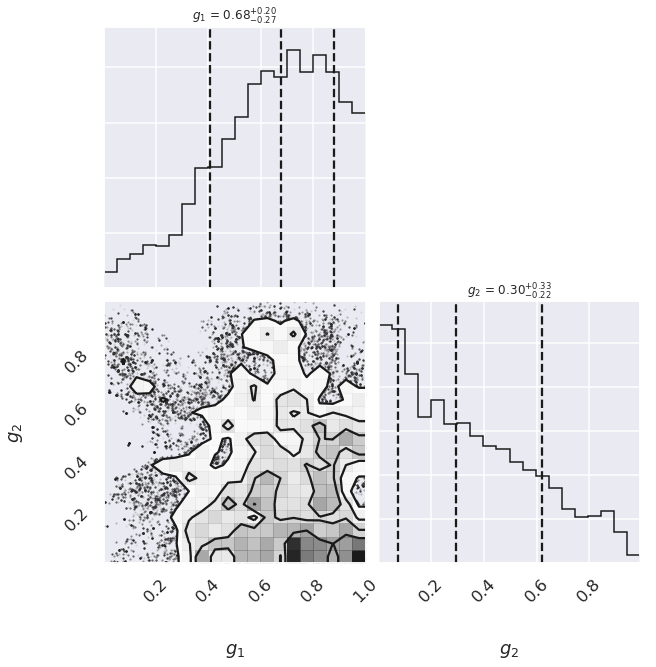

In [20]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
# plot a corner plot with the posterior distribution
# Note that the intercept and the slope correspond to 
#  the first two entries in the parameter array.
fig = corner.corner(samples[:,2:4], labels=[r"$g_1$", r"$g_2$"],
                    quantiles=[0.16, 0.5, 0.84],fig=fig,
                    show_titles=True, title_kwargs={"fontsize": 12})

print("g1 mean: {0:.2f}".format(samples[:, 2].mean()))
print("g2 mean: {0:.2f}".format(samples[:, 3].mean()))

In [21]:
theta3 = np.mean(samples[:, :2], 0)
g = np.mean(samples[:, 2:], 0)
outliers = (g < 0.5)

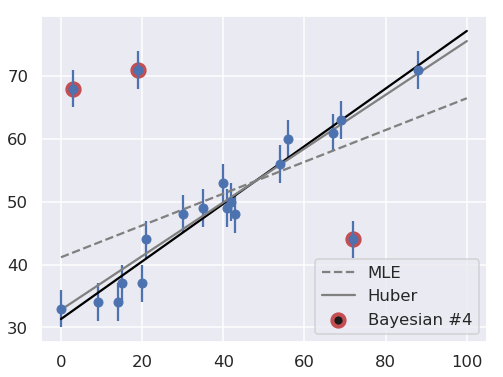

In [22]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, sig0, fmt='o')

ax.plot(xfit, theta3[0] + theta3[1] * xfit, color='black')
ax.scatter(x[outliers], y[outliers], 
            marker='o', s=150, edgecolors='r', linewidths=4, c='k',
            label='Bayesian #4')

ax.plot(xfit, theta_MLE[0] + theta_MLE[1] * xfit, 
        color='gray',ls='--',label='MLE')
ax.plot(xfit, theta2[0] + theta2[1] * xfit, 
        color='gray',ls='-',label='Huber')
ax.legend(loc='best');

## A brief explaination how each of the method work

This model deals with outliers by expanding the model with some parameters, nuisance parameters. Labelled as
{gi}, these parameters are a series of weights which range from 0 to 1 and encode for each point i the 
degree to which it fits the model. When gi=0, the point is labelled as an outlier. Then a Gaussian of the width is used to compute the likelihood. 

## Questions:

This equation is very aesthetically pleasing to me. I do not understand how they(or you) came to this equation. I would love more of a breakdown of the thought process of how this equation was made. I really would like a link to a more in depth breakdown of how these equations work. I spent hours looking for more detailed elaborations. I only found one for the Huber loss, but none for the others that was as detailed as I would like.  